In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
import seaborn as sns
from  datetime import datetime, timedelta

import os
import gc

In [237]:
path = "C:/Users/Paula/Documents/UvA/AFCS - Applied Forecasting in Complex Systems/Project/AFCS-M5/Data"

sales_train = pd.read_csv(os.path.join(path, "sales_train_validation_afcs2021.csv"))
sales_test = pd.read_csv(os.path.join(path, "sales_test_validation_afcs2021.csv"))
calendar = pd.read_csv(os.path.join(path, "calendar_afcs2021.csv"))
prices = pd.read_csv(os.path.join(path, "sell_prices_afcs2021.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission_afcs2021.csv"))

In [238]:
# sales_train.head()

In [239]:
sales_train
print('Sales dataframe dimensions:', sales_train.shape)

# give some infos on columns types and number of null values
sales_info=pd.DataFrame(sales_train.dtypes).T.rename(index={0:'column type'})
sales_info=sales_info.append(pd.DataFrame(sales_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
sales_info=sales_info.append(pd.DataFrame(sales_train.max()).T.rename(index={0:'Max value'}))
sales_info.loc['Max value'][0:6] = 0
print('Max sales: '+str(sales_info.loc['Max value'].max()))
sales_info
# sales.info()

Sales dataframe dimensions: (823, 1914)
Max sales: 385


,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
column type,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Max value,0,0,0,0,0,0,159,97,187,162,104,75,72,54,107,133,135,122,97,68,95,100,132,111,74,...,68,61,74,74,54,77,61,51,68,97,85,74,56,67,55,84,75,83,81,55,60,55,70,102,66


In [240]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales_train[col] = 0
    sales_train[col] = sales_train[col].astype(np.int16)

In [242]:
print(sales_train.info())
# print(sales_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Columns: 1942 entries, id to d_1969
dtypes: category(1), int16(228), int8(1713)
memory usage: 1.7 MB
None


In [241]:
def downcast(df):
    cols = df.dtypes.index.tolist() 
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%m/%d/%Y')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales_train = downcast(sales_train)
sales_test = downcast(sales_test)
prices = downcast(prices)
calendar = downcast(calendar)

## Combine columns from the different Dataframes:

In [266]:
# Combine columns from the different Dataframes:
calendar['d'] = calendar.index
calendar['d'] = calendar['d'].apply(lambda row: 'd_'+str(row+1))
if 'item_id' in prices.columns:
    prices['item_id'] = prices['item_id'].apply(lambda row: row+ '_TX_3_validation') 
    prices = prices.rename(columns={"item_id": "id"})

df = pd.melt(sales_train, id_vars=['id'], var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['id','wm_yr_wk'], how='left')
df = df.drop(columns=['store_id'])

In [267]:
df.head()

,id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
0,FOODS_3_001_TX_3_validation,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,2.279297
1,FOODS_3_002_TX_3_validation,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
2,FOODS_3_003_TX_3_validation,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
3,FOODS_3_004_TX_3_validation,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
4,FOODS_3_005_TX_3_validation,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,1.679688


**Event types**: 'Cultural', 'Religious', 'National', 'Sporting'

**Weekdays** are also in **wday** from 1-7, starting on Saturday

In [247]:
def get_weekend(df):
    df_days = df
    df_days['weekend'] = np.logical_or(df['wday'] == 1, df['wday'] == 2)
    df_days['weekday'] = df_days['weekend'] == 0
    return df_days

In [264]:
def get_events_type(df):
    df_events = df
    for ev in list(df['event_type_1'].unique())[1:]:
        df[ev] = np.logical_or(df['event_type_1'] == ev, df['event_type_2'] == ev)
    return df_events

In [268]:
df = get_weekend(df)
df = get_events_type(df)
df.head()

,id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price,weekend,Sporting,Cultural,National,Religious
0,FOODS_3_001_TX_3_validation,d_1,0,2011-01-29,11101,False,1,1,2011,NaN,NaN,NaN,NaN,0,2.279297,True,False,False,False,False
1,FOODS_3_002_TX_3_validation,d_1,0,2011-01-29,11101,False,1,1,2011,NaN,NaN,NaN,NaN,0,NaN,True,False,False,False,False
2,FOODS_3_003_TX_3_validation,d_1,0,2011-01-29,11101,False,1,1,2011,NaN,NaN,NaN,NaN,0,NaN,True,False,False,False,False
3,FOODS_3_004_TX_3_validation,d_1,0,2011-01-29,11101,False,1,1,2011,NaN,NaN,NaN,NaN,0,NaN,True,False,False,False,False
4,FOODS_3_005_TX_3_validation,d_1,0,2011-01-29,11101,False,1,1,2011,NaN,NaN,NaN,NaN,0,1.679688,True,False,False,False,False


HOBBIES_1_001 sold/price: -0.062005085405233897
HOBBIES_1_010 sold/price: -0.1749232323041529
HOBBIES_2_001 sold/price: -0.07080445437807234
HOBBIES_2_100 sold/price: 0.12824629378020572
HOUSEHOLD_1_001 sold/price: -0.025078362179926022
HOUSEHOLD_1_010 sold/price: -0.10706557602462254
HOUSEHOLD_2_001 sold/price: 0.041250283557046574
HOUSEHOLD_2_100 sold/price: 0.025006340823200423
FOODS_1_001 sold/price: -0.11165616264250212
FOODS_1_010 sold/price: 0.007438605518531248
FOODS_2_001 sold/price: 0.11039703892048788
FOODS_2_100 sold/price: -0.04212269256421


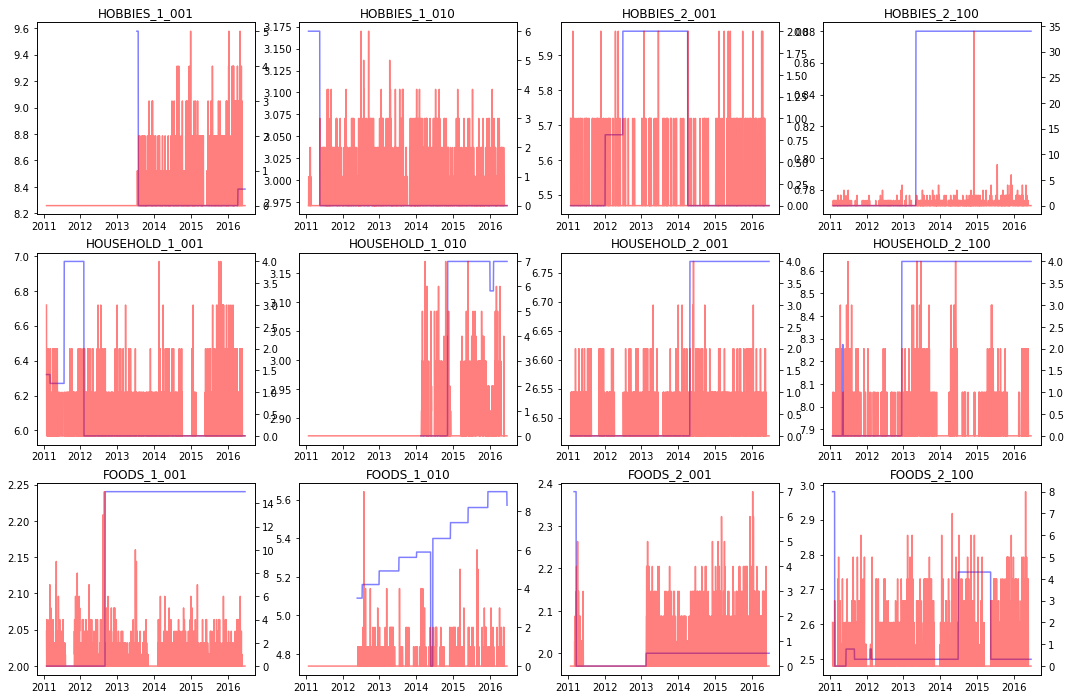

In [14]:
# Easily check the relationship between price and sold for a specific product
# Calculate the correlation coefficient between sold and price

itemID =['HOBBIES_1_001','HOBBIES_1_010','HOBBIES_2_001','HOBBIES_2_100',
        'HOUSEHOLD_1_001','HOUSEHOLD_1_010','HOUSEHOLD_2_001','HOUSEHOLD_2_100',
        'FOODS_1_001','FOODS_1_010','FOODS_2_001','FOODS_2_100']


# For CA_1 store:
r,c=0,0
fig, ax = plt.subplots(3,4,figsize=(18, 12))
df_store = df[df['store_id']=='CA_1']
for i in range(0,12):
    item_df = df_store[df_store['item_id']==itemID[i]]
    print('{} sold/price:'.format(itemID[i]),item_df['sold'].corr(item_df['sell_price']))
    ax2 = ax[r][c].twinx() 
    ax[r][c].plot(item_df['date'],item_df['sell_price'],color='b',alpha=0.5)
    ax2.plot(item_df['date'],item_df['sold'],color='r',alpha=0.5)
    ax[r][c].set_title(itemID[i])
    c+=1
    if c ==4:
        c=0
        r+=1
#plt.savefig('CA_1_price.png')
plt.show()

Price fluctuations are small, with no identifyable patterns.

It is difficult to refer to the correlation coefficient because the fluctuation interval between sold and price is different, but as far as the figure is confirmed, there is no correlation between the price fluctuation of the product and the number of units sold.

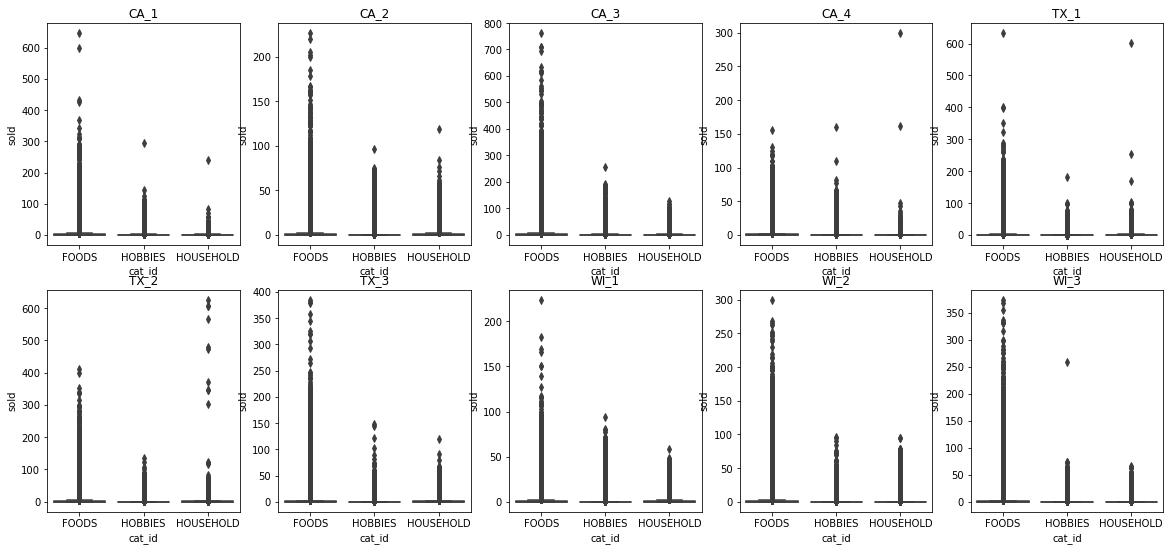

In [9]:
state_id_lst = df['state_id'].unique()
store_id_lst = df['store_id'].unique()
category = df['cat_id'].unique()

fig, ax = plt.subplots(2,5,figsize=(20, 9))
r,c=0,0
for store_id in store_id_lst:
    df_store = df[df['store_id']==store_id]
    sns.boxplot(x='cat_id',y='sold',data=df_store,ax=ax[r][c])
    ax[r][c].set_title(store_id)
    c +=1
    if c==5:
        r+=1
        c=0
#plt.savefig('Dist_sold.png')
plt.show()